# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# # Here is a helping code that will download and unzip the dataset for you.
# # Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , SimpleRNN, Dropout , TimeDistributed
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error , mean_absolute_error
from keras.layers import SimpleRNN, Dropout

In [3]:
df = pd.read_csv('/content/Traffic Data.csv')
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [5]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [8]:
# plt.figure(figsize=(20,7))
# sns.lineplot(x = 'date_time' , y = 'traffic_volume' , data = df)
# plt.figure(figsize=(20,7))
# ;

<Figure size 2000x700 with 0 Axes>

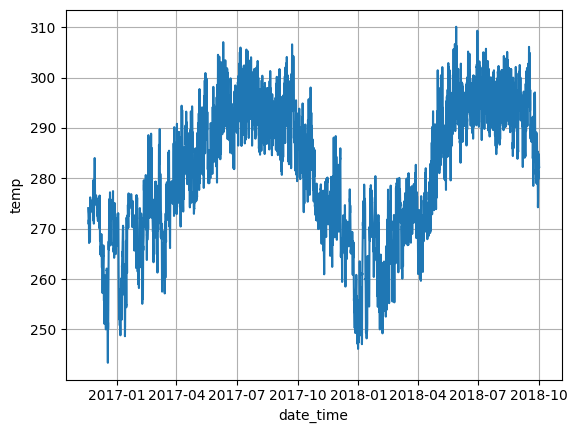

<Figure size 2000x700 with 0 Axes>

In [16]:
# year = df['date_time'].dt.year
sns.lineplot(x = 'date_time' , y = 'temp' , data = df)
plt.grid(True)
plt.figure(figsize=(20,7))

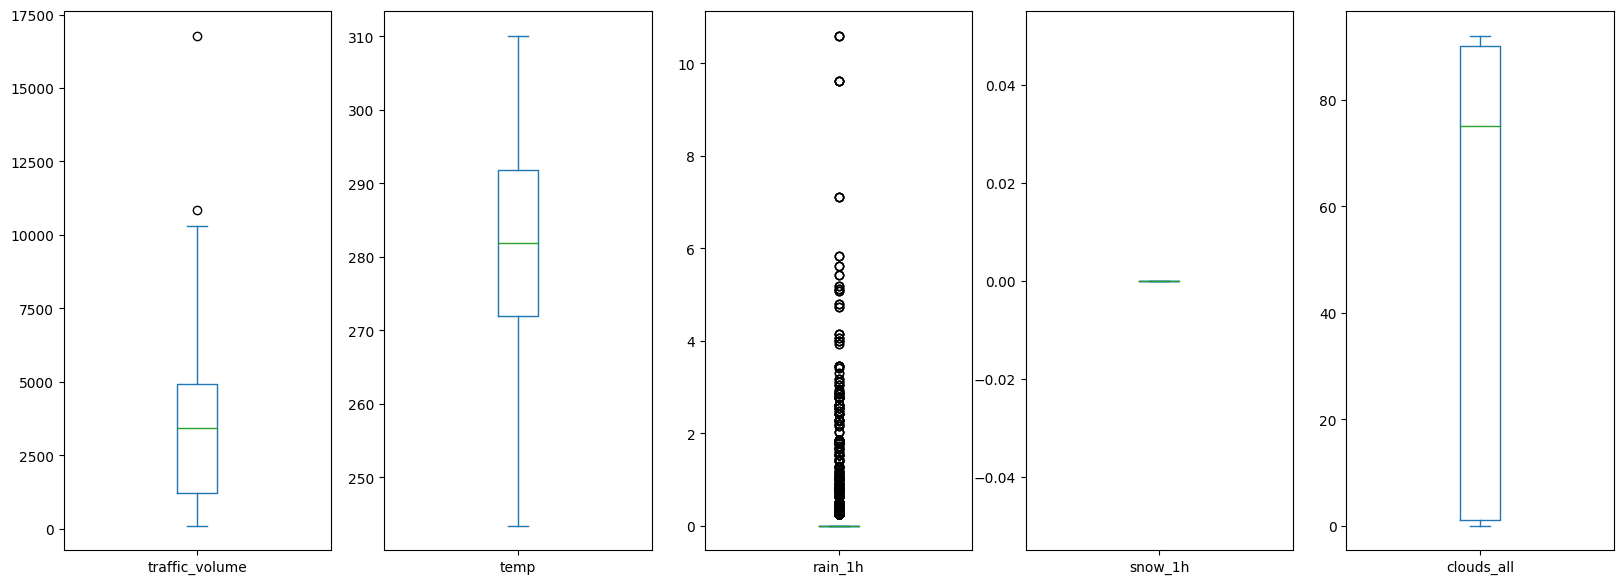

In [17]:
df.plot(kind= 'box' , figsize=(20,7) , subplots=True);

In [18]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [19]:
# i can't use from seasonal_decompose ,, because there is a null value

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [20]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [21]:
df['traffic_volume'] =df['traffic_volume'].fillna(df['traffic_volume'].mean())

<ipython-input-21-c746260363b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['traffic_volume'] =df['traffic_volume'].fillna(df['traffic_volume'].mean())


In [22]:
df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [23]:
 df = df.drop_duplicates()

In [24]:
# now i will use seasonal_decompose after filling the missign values

In [25]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [26]:
result = seasonal_decompose(df['traffic_volume'] , model = 'additive' , period = 30)

<Figure size 15000x3000 with 0 Axes>

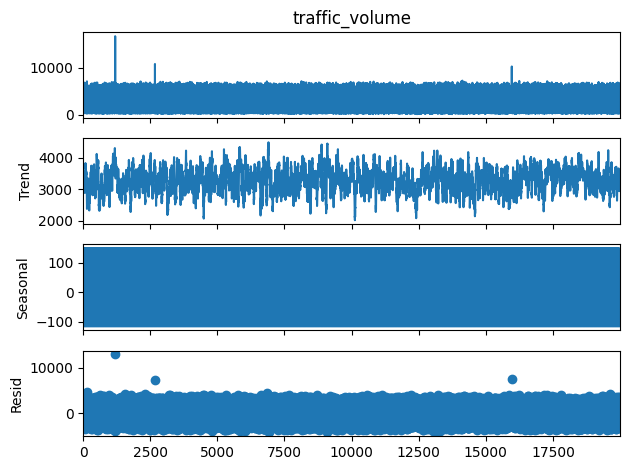

In [27]:
plt.figure(figsize=(150, 30))
result.plot();

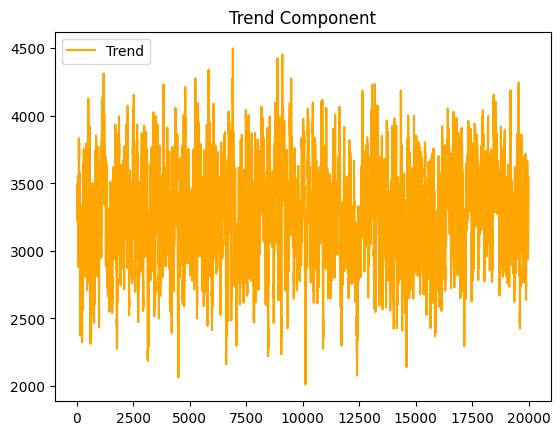

<Figure size 2000x800 with 0 Axes>

In [28]:
plt.plot(result.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend Component')
plt.figure(figsize=(20, 8));

In [29]:
# i will sort the df depending on date to create correct lag

In [30]:
df = df.sort_values(by = 'date_time' , ascending=True)

In [31]:
df['lag_date_time'] = df['date_time'].shift(1)

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [32]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)

In [33]:
df['Difference_between_traffic_volume'] = df['traffic_volume'] - df['prev_traffic_volume']

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19988 entries, 14496 to 3795
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   traffic_volume                     19988 non-null  float64       
 1   temp                               19988 non-null  float64       
 2   rain_1h                            19988 non-null  float64       
 3   snow_1h                            19988 non-null  float64       
 4   clouds_all                         19988 non-null  int64         
 5   weather_main                       19988 non-null  object        
 6   weather_description                19988 non-null  object        
 7   date_time                          19988 non-null  datetime64[ns]
 8   lag_date_time                      19987 non-null  datetime64[ns]
 9   prev_traffic_volume                19987 non-null  float64       
 10  Difference_between_traffic_volume  1

In [35]:
df['day_of_week'] = df['date_time'].dt.day_of_week
df['month'] = df['date_time'].dt.month
df['day_of_year'] = df['date_time'].dt.day_of_year

In [36]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,lag_date_time,prev_traffic_volume,Difference_between_traffic_volume,day_of_week,month,day_of_year
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00,NaT,NaN,NaN,4,11,323
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00,2016-11-18 15:00:00,4872.0,0.0,4,11,323
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00,2016-11-18 15:00:00,4872.0,0.0,4,11,323
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00,2016-11-18 15:00:00,4872.0,202.0,4,11,323
18985,5074.0,273.84,0.0,0.0,90,Snow,heavy snow,2016-11-18 16:00:00,2016-11-18 16:00:00,5074.0,0.0,4,11,323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6605,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,2018-09-30 18:00:00,3947.0,-404.0,6,9,273
14241,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2018-09-30 19:00:00,3543.0,-762.0,6,9,273
9500,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2018-09-30 20:00:00,2781.0,-622.0,6,9,273
15201,1450.0,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,2018-09-30 21:00:00,2159.0,-709.0,6,9,273


In [37]:
df['weather_description'].unique()

array(['mist', 'fog', 'heavy snow', 'light snow', 'haze',
       'overcast clouds', 'sky is clear', 'broken clouds',
       'scattered clouds', 'few clouds', 'light rain', 'moderate rain',
       'light intensity drizzle', 'snow', 'freezing rain',
       'shower drizzle', 'drizzle', 'proximity thunderstorm',
       'heavy intensity rain', 'proximity shower rain', 'thunderstorm',
       'light shower snow', 'Sky is Clear', 'sleet',
       'thunderstorm with heavy rain', 'heavy intensity drizzle',
       'light rain and snow', 'thunderstorm with light rain',
       'proximity thunderstorm with rain',
       'thunderstorm with light drizzle',
       'proximity thunderstorm with drizzle',
       'light intensity shower rain', 'thunderstorm with rain', 'smoke'],
      dtype=object)

In [38]:
df = df.drop(columns='weather_description')

In [39]:
df.reset_index(drop=True, inplace=True)


In [40]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,lag_date_time,prev_traffic_volume,Difference_between_traffic_volume,day_of_week,month,day_of_year
0,4872.0,274.08,0.0,0.0,90,Mist,2016-11-18 15:00:00,NaT,NaN,NaN,4,11,323
1,4872.0,274.08,0.0,0.0,90,Fog,2016-11-18 15:00:00,2016-11-18 15:00:00,4872.0,0.0,4,11,323
2,4872.0,274.08,0.0,0.0,90,Snow,2016-11-18 15:00:00,2016-11-18 15:00:00,4872.0,0.0,4,11,323
3,5074.0,273.84,0.0,0.0,90,Mist,2016-11-18 16:00:00,2016-11-18 15:00:00,4872.0,202.0,4,11,323
4,5074.0,273.84,0.0,0.0,90,Snow,2016-11-18 16:00:00,2016-11-18 16:00:00,5074.0,0.0,4,11,323
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19983,3543.0,283.45,0.0,0.0,75,Clouds,2018-09-30 19:00:00,2018-09-30 18:00:00,3947.0,-404.0,6,9,273
19984,2781.0,282.76,0.0,0.0,90,Clouds,2018-09-30 20:00:00,2018-09-30 19:00:00,3543.0,-762.0,6,9,273
19985,2159.0,282.73,0.0,0.0,90,Thunderstorm,2018-09-30 21:00:00,2018-09-30 20:00:00,2781.0,-622.0,6,9,273
19986,1450.0,282.09,0.0,0.0,90,Clouds,2018-09-30 22:00:00,2018-09-30 21:00:00,2159.0,-709.0,6,9,273


In [41]:
df = df.dropna()

In [42]:
dummie = pd.get_dummies(df,columns=['weather_main'] , dtype=(int))
df = dummie

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19987 entries, 1 to 19987
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   traffic_volume                     19987 non-null  float64       
 1   temp                               19987 non-null  float64       
 2   rain_1h                            19987 non-null  float64       
 3   snow_1h                            19987 non-null  float64       
 4   clouds_all                         19987 non-null  int64         
 5   date_time                          19987 non-null  datetime64[ns]
 6   lag_date_time                      19987 non-null  datetime64[ns]
 7   prev_traffic_volume                19987 non-null  float64       
 8   Difference_between_traffic_volume  19987 non-null  float64       
 9   day_of_week                        19987 non-null  int32         
 10  month                              1998

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [44]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,date_time,lag_date_time,prev_traffic_volume,Difference_between_traffic_volume,day_of_week,...,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Thunderstorm
1,4872.0,274.08,0.0,0.0,90,2016-11-18 15:00:00,2016-11-18 15:00:00,4872.0,0.0,4,...,0,0,0,1,0,0,0,0,0,0
2,4872.0,274.08,0.0,0.0,90,2016-11-18 15:00:00,2016-11-18 15:00:00,4872.0,0.0,4,...,0,0,0,0,0,0,0,0,1,0
3,5074.0,273.84,0.0,0.0,90,2016-11-18 16:00:00,2016-11-18 15:00:00,4872.0,202.0,4,...,0,0,0,0,0,1,0,0,0,0
4,5074.0,273.84,0.0,0.0,90,2016-11-18 16:00:00,2016-11-18 16:00:00,5074.0,0.0,4,...,0,0,0,0,0,0,0,0,1,0
5,5074.0,273.84,0.0,0.0,90,2016-11-18 16:00:00,2016-11-18 16:00:00,5074.0,0.0,4,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19983,3543.0,283.45,0.0,0.0,75,2018-09-30 19:00:00,2018-09-30 18:00:00,3947.0,-404.0,6,...,0,1,0,0,0,0,0,0,0,0
19984,2781.0,282.76,0.0,0.0,90,2018-09-30 20:00:00,2018-09-30 19:00:00,3543.0,-762.0,6,...,0,1,0,0,0,0,0,0,0,0
19985,2159.0,282.73,0.0,0.0,90,2018-09-30 21:00:00,2018-09-30 20:00:00,2781.0,-622.0,6,...,0,0,0,0,0,0,0,0,0,1
19986,1450.0,282.09,0.0,0.0,90,2018-09-30 22:00:00,2018-09-30 21:00:00,2159.0,-709.0,6,...,0,1,0,0,0,0,0,0,0,0


In [45]:
df.set_index('date_time' , inplace=True)

In [46]:
df = df.drop(columns = 'lag_date_time')

In [47]:
train_size = int(len(df) *0.8)
test_size = len(df) - train_size

In [48]:
train = df.iloc[:train_size]
test = df.iloc[train_size+1:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [49]:
std = StandardScaler()
train = std.fit_transform(train)


In [50]:
test = std.transform(test)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [51]:
# model 1 = LSTM
# model 2 = RNN

In [52]:
# note :
# the structure of the model it will be simple to time utilization

In [53]:
train.shape

(15989, 20)

In [54]:
n_step = 6
batch_size =1
generator = TimeseriesGenerator(train,train,length=n_step , batch_size=batch_size)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [55]:
          # LSTM(4 , activation='relu',input_shape = (n_step,20)),


In [56]:
# LSTM

model = Sequential([
          LSTM(4 ,input_shape = (n_step,20)),
          Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405 (1.58 KB)

 Trainable params: 405 (1.58 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
history = model.fit(generator, epochs=5,verbose=1)

Epoch 1/5
   51/15983 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 0.8907

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15983/15983 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - loss: 0.9507
Epoch 2/5
15983/15983 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - loss: 0.8631
Epoch 3/5
15983/15983 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 0.8241
Epoch 4/5
15983/15983 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - loss: 0.8362
Epoch 5/5
15983/15983 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - loss: 0.8319


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [58]:
test_generator = TimeseriesGenerator(test, test, length=n_step, batch_size=batch_size)


In [59]:
test_pred = model.predict(test_generator)

3991/3991 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


In [60]:
test_pred.shape

(3991, 1)

In [61]:
test.shape

(3997, 20)

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [62]:
test_pred_extended = np.zeros((test_pred.shape[0], 20))
test_pred_extended[:, 0] = test_pred[:, 0]

In [63]:
test_pred_rescaled = std.inverse_transform(test_pred_extended)

In [64]:
test_pred_rescaled = test_pred_rescaled[:, 0]

In [65]:
test_adjusted = test[n_step:]

In [66]:
test_mse = mean_squared_error(test_adjusted[:, 0], test_pred_rescaled)


In [67]:
test_mse

12366650.295609478

In [68]:
test_rmse = np.sqrt(test_mse)
test_rmse

3516.624844308741

In [69]:
test_mae = mean_absolute_error(test_adjusted[:, 0], test_pred_rescaled)
test_mae

3506.6619131738507

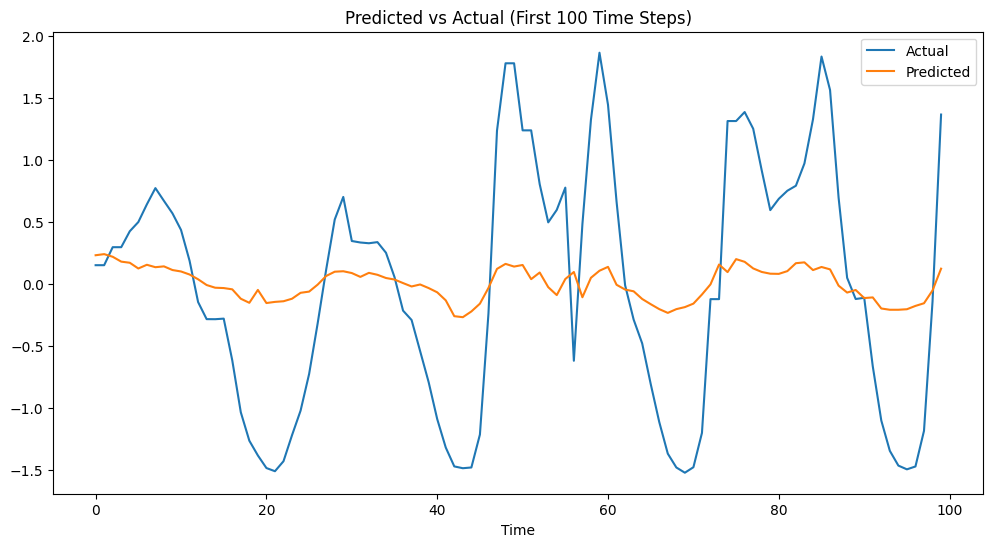

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(test_adjusted[:100, 0], label='Actual')
plt.plot(test_pred[:100], label='Predicted')
plt.title('Predicted vs Actual (First 100 Time Steps)')
plt.xlabel('Time')
plt.legend()


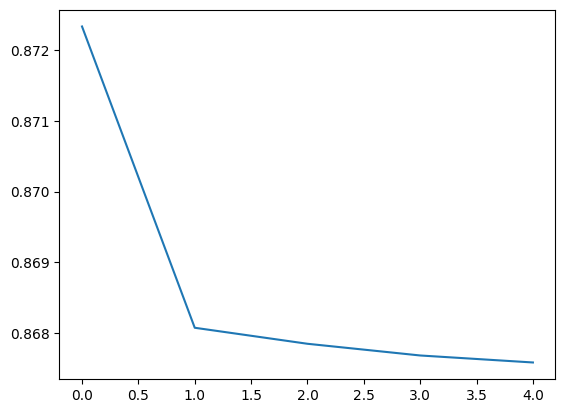

In [71]:
plt.plot(history.history['loss'])

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [72]:
model2 = Sequential([
      SimpleRNN(units=10, return_sequences=False, input_shape=((n_step,20))),
      Dropout(0.5),
      Dense(1)
])
model2.compile(loss='mean_squared_error', optimizer='adam')

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
history2 =model2.fit(generator, epochs=5,verbose=1)

Epoch 1/5
15983/15983 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 1.1479
Epoch 2/5
15983/15983 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 0.9414
Epoch 3/5
15983/15983 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 0.8583
Epoch 4/5
15983/15983 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.8610
Epoch 5/5
15983/15983 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.8275


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [74]:
test_pred2 = model.predict(test_generator)


3991/3991 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [75]:
test_pred_extended2 = np.zeros((test_pred2.shape[0], 20))
test_pred_extended2[:, 0] = test_pred2[:, 0]
test_pred_rescaled2 = std.inverse_transform(test_pred_extended2)
test_pred_rescaled2 = test_pred_rescaled2[:, 0]
test_adjusted2 = test[n_step:]
test_mse2 = mean_squared_error(test_adjusted2[:, 0], test_pred_rescaled2)
test_mse2

12366650.295609478

In [76]:
test_mae2 = mean_absolute_error(test_adjusted2[:, 0], test_pred_rescaled2)
test_mae2

3506.6619131738507

In [77]:
test_rmse2 = np.sqrt(test_mse2)
test_rmse2

3516.624844308741

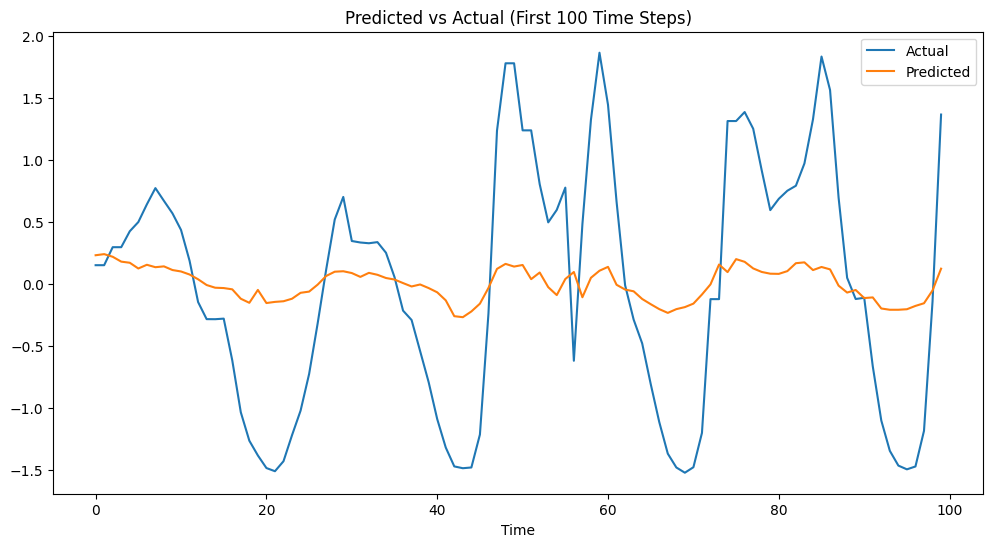

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(test_adjusted2[:100, 0], label='Actual')
plt.plot(test_pred2[:100], label='Predicted')
plt.title('Predicted vs Actual (First 100 Time Steps)')
plt.xlabel('Time')
plt.legend()


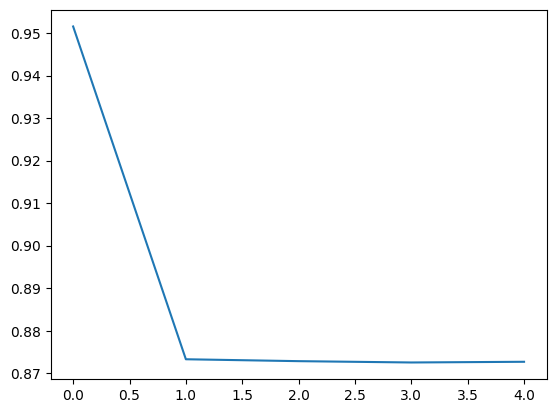

In [79]:
plt.plot(history2.history['loss'] )

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

3. It’s too brief and not enough because of time constraints.         

7.yes there is underfitting because the model architecture its too simple

8. imporve model architecture and add validation loss